In [ ]:
# 코랩에서 한글 깨질 때 실행
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,451 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
plt.rc('font', family='NanumBarunGothic')

### 데이터 불러오기

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/데이콘 구내식당 공모전

/content/drive/MyDrive/Colab Notebooks/데이콘 구내식당 공모전


In [ ]:
train_lunch = pd.read_csv('train_lunch_오후12시날씨포함.csv')
train_dinner = pd.read_csv('train_dinner_오후6시날씨포함.csv') 
test_lunch = pd.read_csv('test_lunch_오후12시날씨포함.csv')
test_dinner = pd.read_csv('test_dinner_오후6시날씨포함.csv')

### EDA

#### 1. 변수 추가

##### 1.1 휴일변수


휴가자수는 휴가시즌, 휴일 근처인 경우 눈에 띄게 많아지기 때문에 식수인원도 평소보다 줄어들것이라 예상

- holidayNext : 휴일 다음날(월요일 제외)
- holidayBefore : 휴일 전날(금요일 제외)
- holidayBoth : 전날과 다음날 모두 휴일인 경우
- 휴일이 양옆으로 낀 평일이거나 휴일 전날의 경우, 식수인원이 낮게 분포했음 (아래 박스그래프)
- 공휴일은 공공데이터 (한국천문연구원_특일 정보, https://www.data.go.kr/data/15012690/openapi.do )에서 가져왔고 근로자의 날(5/1)을 추가로 고려함.

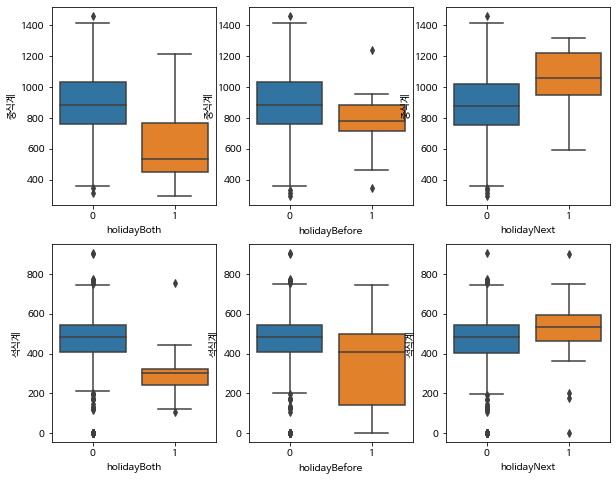

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
sns.boxplot(x=train_lunch['holidayBoth'], y = train_lunch['중식계'])
plt.subplot(2,3,2)
sns.boxplot(x=train_lunch['holidayBefore'], y = train_lunch['중식계'])
plt.subplot(2,3,3)
sns.boxplot(x=train_lunch['holidayNext'], y = train_lunch['중식계'])
plt.subplot(2,3,4)
sns.boxplot(x=train_lunch['holidayBoth'], y = train_lunch['석식계'])
plt.subplot(2,3,5)
sns.boxplot(x=train_lunch['holidayBefore'], y = train_lunch['석식계'])
plt.subplot(2,3,6)
sns.boxplot(x=train_lunch['holidayNext'], y = train_lunch['석식계'])

Q. 휴일근처에는 야근이 적을까?
- NO. 우리가 어떤 민족입니까 야근의 민ㅈ..
  - 시간외근무자수 이상치로 의심되는 대다수가 휴일 전/후 였음 (아래 그래프 주황색)
- 수(요일=2)과 금(요일=4)은 야근을 잘 안하는 요일
- 목요일(요일=3) 시간외 근무수가 700이상인 경우 이상치로 의심됐는데 모두 10월이었음. (10월에 감사 일정이..?)

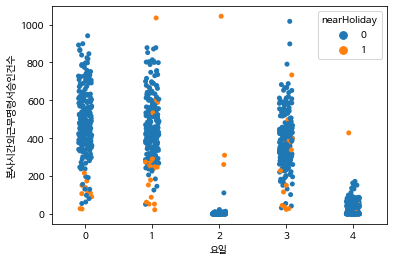

In [ ]:
# 휴일 근처인 경우, nearHoliday
train_lunch['nearHoliday'] = train_lunch['holidayBefore'] + train_lunch['holidayNext'] + train_lunch['holidayBoth']
sns.stripplot(x='요일', y='본사시간외근무명령서승인건수',hue='nearHoliday', 
                data=train_lunch)
plt.show()

##### 1.2 휴가_ratio, 시간외근무_ratio, 출장_ratio

- 사옥출근자수 = 본사정원수 - 본사휴가자수-현본사소속재택근무자수
- 휴가자, 출장자, 시간외 근무자수를 각각 사옥출근자수로 나눠
- 휴가_ratio, 시간외근무_ratio,출장_ratio 생성

In [ ]:
train_lunch['휴가_ratio'] = round(train_lunch['본사휴가자수'] / train_lunch['사옥출근자수'],4)
train_lunch['시간외근무_ratio'] = round(train_lunch['본사시간외근무명령서승인건수'] / train_lunch['사옥출근자수'],4)
train_lunch['출장_ratio'] = round(train_lunch['본사출장자수'] / train_lunch['사옥출근자수'],4)

train_dinner['휴가_ratio'] = round(train_dinner['본사휴가자수'] / train_dinner['사옥출근자수'],4)
train_dinner['시간외근무_ratio'] = round(train_dinner['본사시간외근무명령서승인건수'] / train_dinner['사옥출근자수'],4)
train_dinner['출장_ratio'] = round(train_dinner['본사출장자수'] / train_dinner['사옥출근자수'],4)

In [ ]:
# test
test_lunch['휴가_ratio'] = round(test_lunch['본사휴가자수'] / test_lunch['사옥출근자수'],4)
test_lunch['시간외근무_ratio'] = round(test_lunch['본사시간외근무명령서승인건수'] / test_lunch['사옥출근자수'],4)
test_lunch['출장_ratio'] = round(test_lunch['본사출장자수'] / test_lunch['사옥출근자수'],4)

test_dinner['휴가_ratio'] = round(test_dinner['본사휴가자수'] / test_dinner['사옥출근자수'],4)
test_dinner['시간외근무_ratio'] = round(test_dinner['본사시간외근무명령서승인건수'] / test_dinner['사옥출근자수'],4)
test_dinner['출장_ratio'] = round(test_dinner['본사출장자수'] / test_dinner['사옥출근자수'],4)

##### 1.3 날씨

- 경남 진주 점심(12시), 저녁(18시) 날씨 가져옴 (출처 : 종관기상관측(ASOS), https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36 )
- 날씨가 너무 춥거나 더우면 외식보다는 구내식당 이용률이 높아질 것이라 예상하고 체감온도, 불쾌지수를 계산

In [ ]:
train_lunch['불쾌지수'] = 1.8*train_lunch['기온(°C)'] - 0.55*(100-train_lunch['습도(%)'])/100*(1.8*train_lunch['기온(°C)']-26) + 32
train_dinner['불쾌지수'] = 1.8*train_dinner['기온(°C)'] - 0.55*(100-train_dinner['습도(%)'])/100*(1.8*train_dinner['기온(°C)']-26) + 32

train_lunch['체감온도'] = 13.12 + 0.6215*train_lunch['기온(°C)']-11.37*(train_lunch['풍속(m/s)']*3.6)**0.15 + 0.3965*(train_lunch['풍속(m/s)']*3.6)**0.15*train_lunch['기온(°C)']
train_dinner['체감온도'] = 13.12 + 0.6215*train_dinner['기온(°C)']-11.37*(train_dinner['풍속(m/s)']*3.6)**0.15 + 0.3965*(train_dinner['풍속(m/s)']*3.6)**0.15*train_dinner['기온(°C)']

# test 데이터도
test_lunch['불쾌지수'] = 1.8*test_lunch['기온(°C)'] - 0.55*(100-test_lunch['습도(%)'])/100*(1.8*test_lunch['기온(°C)']-26) + 32
test_dinner['불쾌지수'] = 1.8*test_dinner['기온(°C)'] - 0.55*(100-test_dinner['습도(%)'])/100*(1.8*test_dinner['기온(°C)']-26) + 32

test_lunch['체감온도'] = 13.12 + 0.6215*test_lunch['기온(°C)']-11.37*(test_lunch['풍속(m/s)']*3.6)**0.15 + 0.3965*(test_lunch['풍속(m/s)']*3.6)**0.15*test_lunch['기온(°C)']
test_dinner['체감온도'] = 13.12 + 0.6215*test_dinner['기온(°C)']-11.37*(test_dinner['풍속(m/s)']*3.6)**0.15 + 0.3965*(test_dinner['풍속(m/s)']*3.6)**0.15*test_dinner['기온(°C)']

계절성 존재

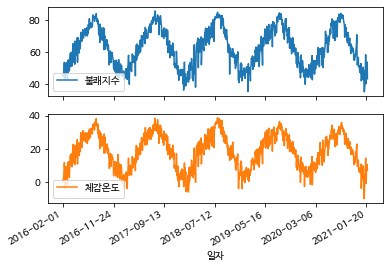

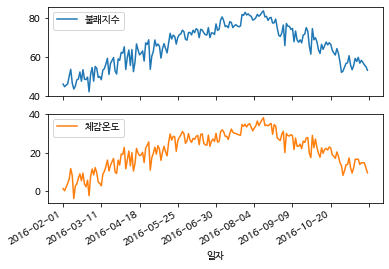

In [ ]:
# 점심
plt.rc('font', family='NanumBarunGothic') 
date_time = train_lunch['일자']
plot_cols = ['불쾌지수','체감온도']
plot_features = train_lunch[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = train_lunch[plot_cols][:200]
plot_features.index = date_time[:200]
_ = plot_features.plot(subplots=True)

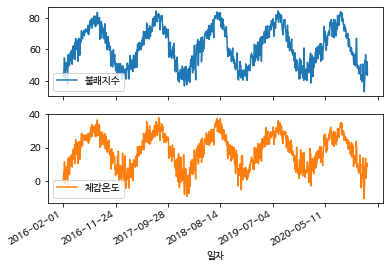

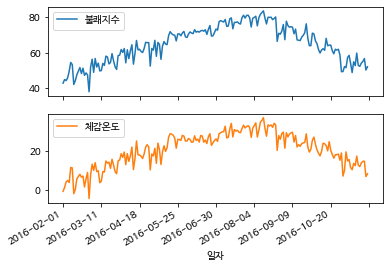

In [ ]:
# 저녁
plt.rc('font', family='NanumBarunGothic') 
date_time = train_dinner['일자']
plot_cols = ['불쾌지수','체감온도']
plot_features = train_dinner[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = train_dinner[plot_cols][:200]
plot_features.index = date_time[:200]
_ = plot_features.plot(subplots=True)

##### 1.4 month변수를 라디안으로

- 11월, 12월, 1월은 서로 간격이 같아야함
- cyclical feature는 주기성이 있는 sin, cos으로 변환.

In [ ]:
train_lunch['month_sin'] = np.sin((train_lunch['month']-1)*(2.*np.pi/12))
train_lunch['month_cos'] = np.cos((train_lunch['month']-1)*(2.*np.pi/12))

train_dinner['month_sin'] = np.sin((train_dinner['month']-1)*(2.*np.pi/12))
train_dinner['month_cos'] = np.cos((train_dinner['month']-1)*(2.*np.pi/12))

# test 도
test_lunch['month_sin'] = np.sin((test_lunch['month']-1)*(2.*np.pi/12))
test_lunch['month_cos'] = np.cos((test_lunch['month']-1)*(2.*np.pi/12))

test_dinner['month_sin'] = np.sin((test_dinner['month']-1)*(2.*np.pi/12))
test_dinner['month_cos'] = np.cos((test_dinner['month']-1)*(2.*np.pi/12))

##### 식단변수

- Q1. 특식이 있는가?
  - 밥, 국, 김치를 제외하고
식수인원 상위 10%에 해당하는 반찬을 특식이라고 가정했으나
반찬마다 식수인원 분산이 컸다.
  - 특정 메뉴가 식수인원에 주는 영향은 크지 않다고 판단.
- Q2. 특정 반찬이 얼마나 자주 나오는가?
  - (2016년 2월 ~2021년 1월) 가장 자주 나온 반찬은 오이무침(38번)
  - 한 달에 한번꼴로 나온다고 해도 60번
  - 반찬이 드물게 반복되므로 특정 반찬에 대한 선호도를 분석하기 어렵다고 판단.
- **결론 : 식수인원 예측 모델에서 제외함**

In [ ]:
# Basic text preprocessing
def split_process(x, q):
    x_ = []
    x = x.split(' ') #공백으로 x를 쪼갬
    for i in x:
        if '(' in i and ':' in i and ')' in i: #()부분은 제외
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_)) # 왜 set를 했지 중복 방지?
    x_.remove('')
    return x_


lunch,dinner = [],[]
for i in ['중식메뉴']:
    lunch += train_lunch[i].apply(lambda x: split_process(x, i)).to_list()

for i in ['석식메뉴']:
    dinner += train_lunch[i].apply(lambda x: split_process(x,i)).to_list()


lunch[:5]

[['계란찜', '쌀밥', '쇠불고기', '잡곡밥', '포기김치', '청포묵무침', '요구르트', '오징어찌개'],
 ['모둠소세지구이', '마늘쫑무침', '가자미튀김', '쌀밥', '잡곡밥', '요구르트', '김치찌개', '배추겉절이'],
 ['카레덮밥', '견과류조림', '쫄면야채무침', '치킨핑거', '포기김치', '요구르트', '팽이장국'],
 ['쌀밥', '주꾸미볶음', '잡곡밥', '부추전', '쇠고기무국', '요구르트', '포기김치', '시금치나물'],
 ['떡국', '쌀밥', '잡곡밥', '포기김치', '요구르트', '우엉잡채', '돈육씨앗강정', '청경채무침']]

In [ ]:
# 특정 반찬이 얼마나 자주 나오는지 확인
lunch2 = [] 

for i in range(len(lunch)):
    for k in lunch[i]:
        lunch2.append(k)

from collections import Counter
lunch_menu_count= Counter(lunch2)
lunch_count = lunch_menu_count.most_common(100)

lunch3 = dict(lunch_count)

In [ ]:
lunch2_2 = []

for i in lunch2:
    if ('김치' not in i) & ('밥' not in i ) & ('겉절이' not in i) & ('깍두기' not in i) & ('찌개' not in i) & ('국' not in i):
        lunch2_2.append(i)
        
lunch_menu_count2= Counter(lunch2_2)
lunch_count2 = lunch_menu_count2.most_common(60)

lunch3_2 = dict(lunch_count2)

# 빈도 순으로 내림차순 정렬
lunch3_2 = sorted(lunch3_2.items(), key=lambda x: x[1], reverse=True)
lunch3_2

[('오이무침', 38),
 ('오징어볶음', 32),
 ('닭갈비', 30),
 ('버섯불고기', 29),
 ('요구르트', 28),
 ('훈제오리구이', 28),
 ('콩나물무침', 28),
 ('부추생채', 28),
 ('계란말이', 28),
 ('무생채', 26),
 ('꽃게탕', 25),
 ('돈육굴소스볶음', 25),
 ('계란찜', 24),
 ('새송이버섯전', 24),
 ('숙주나물', 24),
 ('짬뽕불고기', 24),
 ('제육볶음', 23),
 ('언양식불고기', 22),
 ('시금치나물', 21),
 ('양파절임', 21),
 ('쌈무', 21),
 ('아삭고추무침', 21),
 ('육개장', 20),
 ('마늘쫑무침', 19),
 ('주꾸미볶음', 19),
 ('메추리알조림', 19),
 ('어묵볶음', 19),
 ('감자채볶음', 19),
 ('우엉잡채', 18),
 ('도토리묵무침', 18),
 ('동태전', 18),
 ('시금치프리타타', 18),
 ('닭볶음탕', 18),
 ('해물파전', 17),
 ('골뱅이무침*소면', 17),
 ('실곤약초무침', 17),
 ('고추잡채*꽃빵', 17),
 ('쫑상추무침', 17),
 ('치킨핑거', 16),
 ('참나물생채', 16),
 ('해물누룽지탕', 16),
 ('양념깻잎지', 16),
 ('갈치구이', 15),
 ('소불고기', 15),
 ('미니채소떡갈비', 15),
 ('석박지', 15),
 ('홍어채무침', 15),
 ('돼지갈비찜', 15),
 ('청경채무침', 14),
 ('옥수수전', 14),
 ('오징어숙회무침', 14),
 ('동그랑땡전', 14),
 ('유자청제육볶음', 14),
 ('과일샐러드', 14),
 ('유린기', 14),
 ('연두부*양념장', 13),
 ('취나물', 13),
 ('탕수어', 13),
 ('통도라지구이', 13),
 ('파래김*양념장', 13)]

#### 변수선택을 위한 heatmap

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


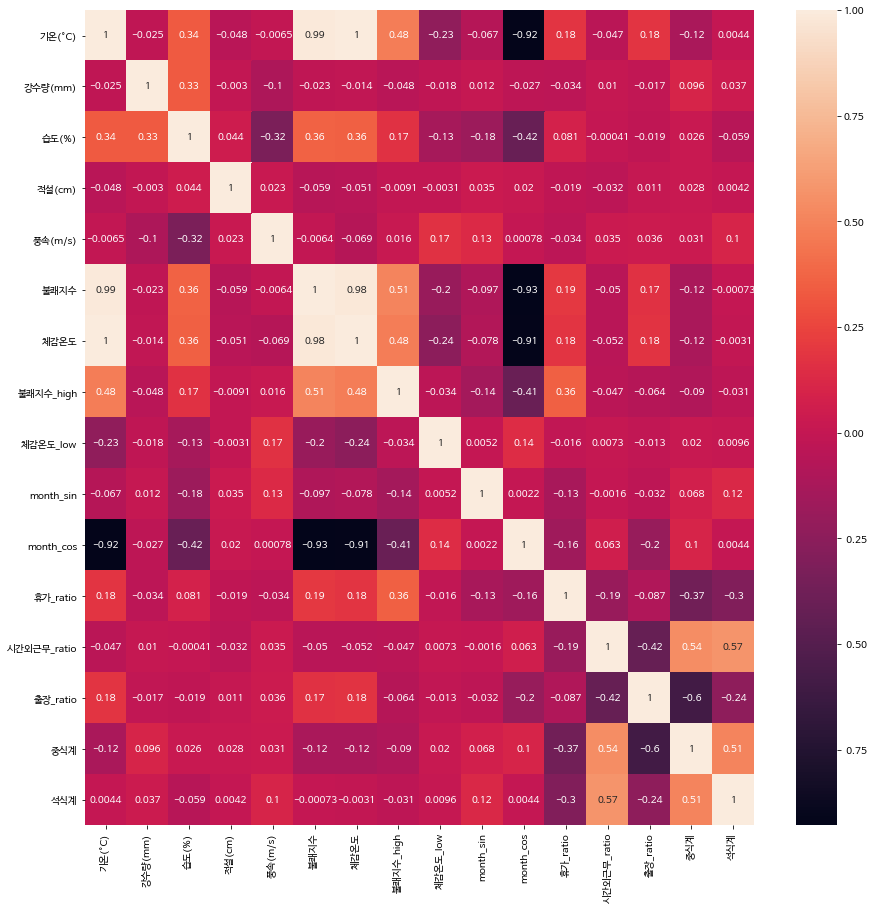

In [ ]:
plt.figure(figsize = (15,15))
heat_cols = ['기온(°C)','강수량(mm)','습도(%)','적설(cm)','풍속(m/s)','불쾌지수','체감온도','불쾌지수_high','체감온도_low',
             'month_sin','month_cos','휴가_ratio','시간외근무_ratio','출장_ratio',
             '중식계','석식계']
sns.heatmap(train_lunch[heat_cols].corr(), annot = True)

모델 변수 선택

- 식수인원과 상관관계가 높게 나온 변수 위주로 선택
- month_cos, 불쾌지수, 체감온도는 상관관계가 매우 높기 때문에 대표로 month_cos 선택


In [ ]:
lunch = train_lunch[['holidayBefore','holidayNext','holidayBoth','불쾌지수','month_cos','휴가_ratio','시간외근무_ratio','출장_ratio','month']]
dinner = train_dinner[['holidayBefore','holidayNext','holidayBoth','month_sin','휴가_ratio','시간외근무_ratio','출장_ratio','month']]

y_lunch = train_lunch['중식계']
y_dinner = train_dinner['석식계']

### 모델링

- variance high 인 상황에서 효과적인 랜덤포레스트
- bias high 인 상황에서 효과적인 XGBoost, CatBoost를 이용.

#### 1차 모델링 : Random Forest

- 선택 변수 :
  - 'holidayBoth','holidayNext','휴가_ratio','시간외근무_ratio','출장_ratio','요일'
- valid 데이터 기준 mae
  - lunch 모델: 116
  - dinner 모델 : 96

In [ ]:
train_lunch_x = train_lunch[['holidayBoth','holidayNext','휴가_ratio','시간외근무_ratio','출장_ratio','요일']] 
train_dinner_x = train_dinner[['holidayBoth','holidayNext','휴가_ratio','시간외근무_ratio','출장_ratio','요일']] 

test_lunch_x = test_lunch[['holidayBoth','holidayNext','휴가_ratio','시간외근무_ratio','출장_ratio','요일']] 
test_dinner_x = test_dinner[['holidayBoth','holidayNext','휴가_ratio','시간외근무_ratio','출장_ratio','요일']] 


train_lunch_y = train_lunch['중식계']
train_dinner_y = train_dinner['석식계']

train set의 마지막 50일은 valid로 분리

In [ ]:

# train, valid 분리

X_train_lunch = train_lunch_x[:-50]
X_valid_lunch = train_lunch_x[-50:]

X_train_dinner = train_dinner_x[:-50]
X_valid_dinner = train_dinner_x[-50:]

Y_train_lunch = train_lunch_y[:-50]
Y_valid_lunch = train_lunch_y[-50:]

Y_train_dinner = train_dinner_y[:-50]
Y_valid_dinner = train_dinner_y[-50:]

print('X_train_lunch 의 shape : ', X_train_lunch.shape)
print('X_valid_lunch 의 shape : ', X_valid_lunch.shape)
print('X_train_dinner 의 shape : ', X_train_dinner.shape)
print('X_valid_dinner 의 shape : ', X_valid_dinner.shape)

X_train_lunch 의 shape :  (1155, 6)
X_valid_lunch 의 shape :  (50, 6)
X_train_dinner 의 shape :  (1112, 6)
X_valid_dinner 의 shape :  (50, 6)


In [ ]:

from sklearn.model_selection import GridSearchCV

param_grid = [ {'n_estimators': [5, 10,20,30],  #decision tree 개수
                'max_features': [4, 5,6]} ] 




from sklearn.ensemble import RandomForestRegressor             
model1_cv = RandomForestRegressor(n_jobs=-1,random_state=42) #train across 5 folds, that's a total of 10*5=50 rounds of training 
model2_cv = RandomForestRegressor(n_jobs=-1,random_state=42)
grid_search1 = GridSearchCV(model1_cv, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True) 
grid_search2 = GridSearchCV(model2_cv, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True) 


grid_search1.fit(X_train_lunch ,Y_train_lunch)
grid_search2.fit(X_train_dinner, Y_train_dinner)
###########

print(grid_search1.best_score_)
print(grid_search1.best_params_)

print(grid_search2.best_score_)
print(grid_search2.best_params_)

pred1 = grid_search1.predict(X_valid_lunch)
pred2 = grid_search2.predict(X_valid_dinner)

# valid set에서의 mae
from sklearn.metrics import mean_absolute_error
print('런치 모델 mae:',mean_absolute_error(Y_valid_lunch, pred1))
print('디너 모델 mae:',mean_absolute_error(Y_valid_dinner, pred2))

-11036.986118326118
{'max_features': 4, 'n_estimators': 30}
-6957.2078923283025
{'max_features': 6, 'n_estimators': 30}
런치 모델 mae: 116.23733333333335
디너 모델 mae: 96.79733333333336


##### 수정

train과 test의 분포 비교
- train데이터의 분포와 test데이터의 분포가 다르면 과적합될 가능성 있음
  - train의 출장자수 분포가 test 분포에 비해 left skewed되어있어보임
  - 휴가자수의 경우도 비대칭(right skewed)
- 출장자수와 휴가자수를 로그변환한 log_출장자수, log_휴가자수 변수 생성

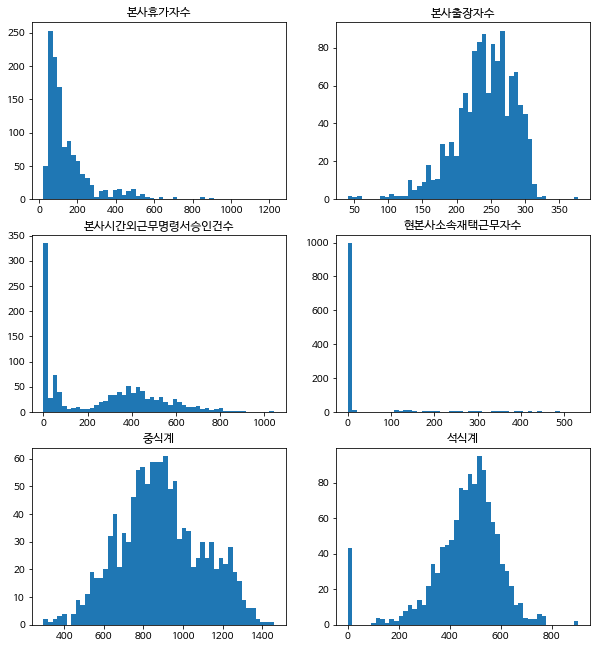

In [ ]:
# train 데이터
plt.figure(figsize=(10,15))
var = ['본사휴가자수','본사출장자수','본사시간외근무명령서승인건수','현본사소속재택근무자수','중식계','석식계']
for i in range(len(var)):
    plt.subplot(4,2,i+1)
    plt.hist(train_lunch[var[i]], 50)
    plt.title('{}'.format(var[i]))

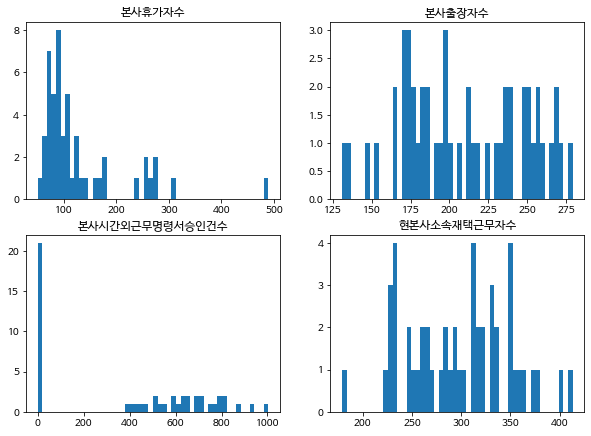

In [ ]:
# test 데이터
plt.figure(figsize=(10,15))
var = ['본사휴가자수','본사출장자수','본사시간외근무명령서승인건수','현본사소속재택근무자수']
for i in range(len(var)):
    plt.subplot(4,2,i+1)
    plt.hist(test_lunch[var[i]], 50)
    plt.title('{}'.format(var[i]))

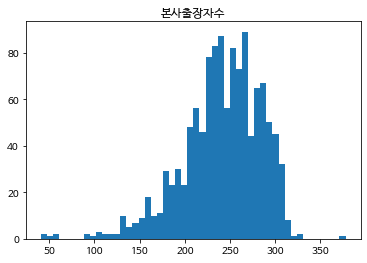

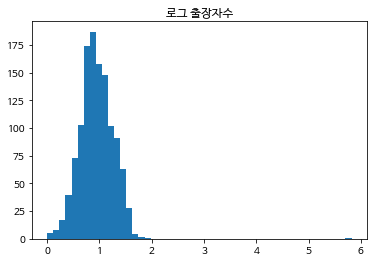

In [ ]:
train_lunch['log_휴가자수'] = np.log(np.array(train_lunch['본사휴가자수']))
train_dinner['log_휴가자수'] = np.log(np.array(train_dinner['본사휴가자수']))
test_lunch['log_휴가자수'] = np.log(np.array(test_lunch['본사휴가자수']))
test_dinner['log_휴가자수'] = np.log(np.array(test_dinner['본사휴가자수']))

# 로그출장도 
max_m = max(train_lunch['본사출장자수'])
max_log_m = max(np.log(max_m-np.array(train_lunch['본사출장자수'])+1))
train_lunch['log_출장자수'] = max_log_m - np.log(max_m-np.array(train_lunch['본사출장자수'])+1)
test_lunch['log_출장자수'] = max_log_m - np.log(max_m-np.array(test_lunch['본사출장자수'])+1)
train_dinner['log_출장자수'] = max_log_m - np.log(max_m-np.array(train_dinner['본사출장자수'])+1)
test_dinner['log_출장자수'] = max_log_m - np.log(max_m-np.array(test_dinner['본사출장자수'])+1)

plt.hist(train_lunch['본사출장자수'],50)
plt.title('본사출장자수')
plt.show()
plt.hist(train_lunch['log_출장자수'], 50)
plt.title('로그 출장자수')
plt.show()

# '로그출장자수' 그래프를 보면 위쪽으로 이상치 의심되는 값들이 있었음 
# 99퍼센타일 이상을 99퍼센타일로 대체
a99 = np.quantile(train_lunch['log_출장자수'],0.99)
train_lunch.loc[train_lunch['log_출장자수'] >= a99,'log_출장자수'] = a99
train_dinner.loc[train_lunch['log_출장자수'] >= a99,'log_출장자수'] = a99



###### 코로나 전후 비교

- 시간외 근무 비율 : 코로나 확산기였던 2020년 연말에 약간 늘었음.
- 휴가, 출장 비율 : 큰 변화는 없었음


[(0.0, 25.0), Text(0.5, 1.0, '2021')]

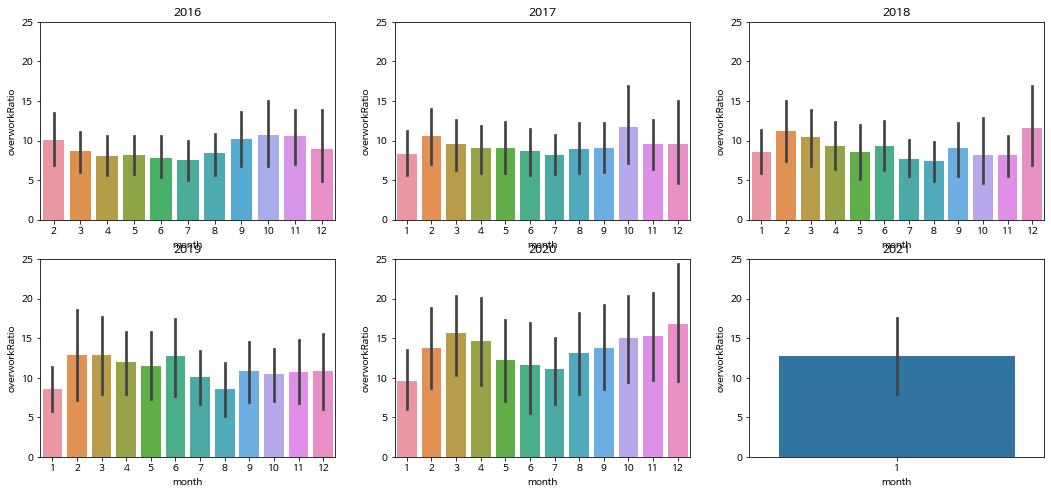

In [ ]:
# 야근 비율(시간외근무 비율)
def year_df(y, data):
    data['overworkRatio'] = data['시간외근무_ratio']*100
    return data[data['year']==y]


figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=year_df(2016, train_lunch), x="month", y="overworkRatio", ax=ax1)
sns.barplot(data=year_df(2017, train_lunch), x="month", y="overworkRatio", ax=ax2)
sns.barplot(data=year_df(2018, train_lunch), x="month", y="overworkRatio", ax=ax3)
sns.barplot(data=year_df(2019, train_lunch), x="month", y="overworkRatio", ax=ax4)
sns.barplot(data=year_df(2020, train_lunch), x="month", y="overworkRatio", ax=ax5)
sns.barplot(data=year_df(2021, train_lunch), x="month", y="overworkRatio", ax=ax6)

ax1.set(title="2016", ylim=(0,25))
ax2.set(title="2017", ylim=(0,25))
ax3.set(title="2018", ylim=(0,25))
ax4.set(title="2019", ylim=(0,25))
ax5.set(title="2020", ylim=(0,25))
ax6.set(title="2021", ylim=(0,25))

#### 2차 모델링 : Catboost

- 원핫인코딩 변수가 sparse하면 catboost모델의 성능이 떨어질 수 있으므로
  - 요일 변수 대신 월별+요일별 식수인원 평균과 표준편차 변수로 대체
  - holidayBefore, holidayBoth, holidayNext도 마찬가지 방법으로 대체
- public : 82점 나옴

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 28 kB/s 


In [ ]:
# 월별 + 요일별 식수인원 평균
lunch_month_weekday_mean = pd.pivot_table(train_lunch, values = '중식계', index = ['month', '요일'], aggfunc = np.mean).reset_index()
dinner_month_weekday_mean = pd.pivot_table(train_lunch, values = '석식계', index = ['month', '요일'], aggfunc = np.mean).reset_index()

# 데이터에 반영
train_lunch['month_weekday_mean'] = train_lunch.apply(lambda x : lunch_month_weekday_mean.loc[(lunch_month_weekday_mean.month == x['month']) & (lunch_month_weekday_mean['요일'] == x['요일']) ,'중식계'].values[0], axis = 1)
train_dinner['month_weekday_mean'] = train_dinner.apply(lambda x : dinner_month_weekday_mean.loc[(dinner_month_weekday_mean.month == x['month']) & (dinner_month_weekday_mean['요일'] == x['요일']) ,'석식계'].values[0], axis = 1)


In [ ]:
# 월별 + 요일별 식수인원 표준편차
lunch_month_weekday_std = pd.pivot_table(train_lunch, values = '중식계', index = ['month', '요일'], aggfunc = np.std).reset_index()
dinner_month_weekday_std = pd.pivot_table(train_lunch, values = '석식계', index = ['month', '요일'], aggfunc = np.std).reset_index()

# 데이터에 반영
train_lunch['month_weekday_std'] = train_lunch.apply(lambda x : lunch_month_weekday_std.loc[(lunch_month_weekday_std.month == x['month']) & (lunch_month_weekday_std['요일'] == x['요일']) ,'중식계'].values[0], axis = 1)
train_dinner['month_weekday_std'] = train_dinner.apply(lambda x : dinner_month_weekday_std.loc[(dinner_month_weekday_std.month == x['month']) & (dinner_month_weekday_std['요일'] == x['요일']) ,'석식계'].values[0], axis = 1)


In [ ]:
#### test 데이터도
#### train 데이터에서의 월별 + 요일별 평균과 표준편차를 그대로 이용.
# 월별 + 요일별 식수인원
lunch_month_weekday_mean = pd.pivot_table(train_lunch, values = '중식계', index = ['month', '요일'], aggfunc = np.mean).reset_index()
dinner_month_weekday_mean = pd.pivot_table(train_lunch, values = '석식계', index = ['month', '요일'], aggfunc = np.mean).reset_index()

# 데이터에 반영
test_lunch['month_weekday_mean'] = test_lunch.apply(lambda x : lunch_month_weekday_mean.loc[(lunch_month_weekday_mean.month == x['month']) & (lunch_month_weekday_mean['요일'] == x['요일']) ,'중식계'].values[0], axis = 1)
test_dinner['month_weekday_mean'] = test_dinner.apply(lambda x : dinner_month_weekday_mean.loc[(dinner_month_weekday_mean.month == x['month']) & (dinner_month_weekday_mean['요일'] == x['요일']) ,'석식계'].values[0], axis = 1)

# 월별 + 요일별 식수인원 표준편차
lunch_month_weekday_std = pd.pivot_table(train_lunch, values = '중식계', index = ['month', '요일'], aggfunc = np.std).reset_index()
dinner_month_weekday_std = pd.pivot_table(train_lunch, values = '석식계', index = ['month', '요일'], aggfunc = np.std).reset_index()

# 데이터에 반영
test_lunch['month_weekday_std'] = test_lunch.apply(lambda x : lunch_month_weekday_std.loc[(lunch_month_weekday_std.month == x['month']) & (lunch_month_weekday_std['요일'] == x['요일']) ,'중식계'].values[0], axis = 1)
test_dinner['month_weekday_std'] = test_dinner.apply(lambda x : dinner_month_weekday_std.loc[(dinner_month_weekday_std.month == x['month']) & (dinner_month_weekday_std['요일'] == x['요일']) ,'석식계'].values[0], axis = 1)



In [ ]:
# holidayBefore, holidayBoth, holidayNext, 이외 평일
# 각각 중간값 구해서 수치화하여 holiday_category 변수로 대체

def holiday_median(data, var, y):
    tmp = data[data[var] == 1]
    return tmp[y].median()

train_lunch['holiday_category'] = 0
train_lunch['nearHoliday'] = train_lunch['holidayBefore'] + train_lunch['holidayNext'] + train_lunch['holidayBoth']
tmp = train_lunch[train_lunch['nearHoliday'] ==0]
not_holiday = tmp['중식계'].median()

for i in range(train_lunch.shape[0]):
    if train_lunch['holidayBefore'][i] == 1:
        train_lunch['holiday_category'][i] = holiday_median(train_lunch, 'holidayBefore', '중식계')
    elif train_lunch['holidayBoth'][i] == 1:
        train_lunch['holiday_category'][i] = holiday_median(train_lunch, 'holidayBoth', '중식계')
    elif train_lunch['holidayNext'][i] == 1:
        train_lunch['holiday_category'][i] = holiday_median(train_lunch, 'holidayNext', '중식계')
    else:
        train_lunch['holiday_category'][i] = not_holiday

# dinner도    
train_dinner['holiday_category'] = 0
train_dinner['nearHoliday'] = train_dinner['holidayBefore'] + train_dinner['holidayNext'] + train_dinner['holidayBoth']
tmp = train_dinner[train_dinner['nearHoliday'] ==0]
not_holiday = tmp['석식계'].median()

for i in range(train_dinner.shape[0]):
    if train_dinner['holidayBefore'][i] == 1:
        train_dinner['holiday_category'][i] = holiday_median(train_dinner, 'holidayBefore', '석식계')
    elif train_dinner['holidayBoth'][i] == 1:
        train_dinner['holiday_category'][i] = holiday_median(train_dinner, 'holidayBoth', '석식계')
    elif train_dinner['holidayNext'][i] == 1:
        train_dinner['holiday_category'][i] = holiday_median(train_dinner, 'holidayNext', '석식계')
    else:
        train_dinner['holiday_category'][i] = not_holiday


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
# test는 train과 동일하게

test_lunch['holiday_category'] = 0
test_lunch['nearHoliday'] = test_lunch['holidayBefore'] + test_lunch['holidayNext'] + test_lunch['holidayBoth']
not_holiday = train_lunch[train_lunch['nearHoliday'] ==0]['중식계'].median() # train의 median가져옴

for i in range(test_lunch.shape[0]):
    if test_lunch['holidayBefore'][i] == 1:
        test_lunch['holiday_category'][i] = holiday_median(train_lunch, 'holidayBefore', '중식계')# train의 median가져옴
    elif test_lunch['holidayBoth'][i] == 1:
        test_lunch['holiday_category'][i] = holiday_median(train_lunch, 'holidayBoth', '중식계')
    elif test_lunch['holidayNext'][i] == 1:
        test_lunch['holiday_category'][i] = holiday_median(train_lunch, 'holidayNext', '중식계')
    else:
        test_lunch['holiday_category'][i] = not_holiday


test_dinner['holiday_category'] = 0
test_dinner['nearHoliday'] = test_dinner['holidayBefore'] + test_dinner['holidayNext'] + test_dinner['holidayBoth']
not_holiday = train_dinner[train_dinner['nearHoliday'] ==0]['석식계'].median() # train의 median가져옴

for i in range(test_dinner.shape[0]):
    if test_dinner['holidayBefore'][i] == 1:
        test_dinner['holiday_category'][i] = holiday_median(train_dinner, 'holidayBefore', '석식계')# train의 median가져옴
    elif test_dinner['holidayBoth'][i] == 1:
        test_dinner['holiday_category'][i] = holiday_median(train_dinner, 'holidayBoth', '석식계')
    elif test_dinner['holidayNext'][i] == 1:
        test_dinner['holiday_category'][i] = holiday_median(train_dinner, 'holidayNext', '석식계')
    else:
        test_dinner['holiday_category'][i] = not_holiday

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/u

####### 변수선택

In [ ]:
train_lunch_x = train_lunch[['month_weekday_mean','month_weekday_std','log_휴가자수','시간외근무_ratio','log_출장자수','불쾌지수']]  # lunch 모델 피팅 결과 'holiday_category'변수는 중요도가 높지 않아서 제외
train_dinner_x = train_dinner[['holiday_category','month_weekday_mean','month_weekday_std','log_휴가자수','시간외근무_ratio','log_출장자수','month_sin', 'month_cos']]
test_lunch_x = test_lunch[['month_weekday_mean','month_weekday_std','log_휴가자수','시간외근무_ratio','log_출장자수','불쾌지수']]
test_dinner_x = test_dinner[['holiday_category','month_weekday_mean','month_weekday_std','log_휴가자수','시간외근무_ratio','log_출장자수','month_sin', 'month_cos']]

train_lunch_y = train_lunch['중식계']
train_dinner_y = train_dinner['석식계']

# train, valid 분리
X_train_lunch = train_lunch_x[:-50]
X_valid_lunch = train_lunch_x[-50:]

X_train_dinner = train_dinner_x[:-50]
X_valid_dinner = train_dinner_x[-50:]

Y_train_lunch = train_lunch_y[:-50]
Y_valid_lunch = train_lunch_y[-50:]

Y_train_dinner = train_dinner_y[:-50]
Y_valid_dinner = train_dinner_y[-50:]

print('X_train_lunch 의 shape : ', X_train_lunch.shape)
print('X_valid_lunch 의 shape : ', X_valid_lunch.shape)
print('X_train_dinner 의 shape : ', X_train_dinner.shape)
print('X_valid_dinner 의 shape : ', X_valid_dinner.shape)

X_train_lunch 의 shape :  (1155, 6)
X_valid_lunch 의 shape :  (50, 6)
X_train_dinner 의 shape :  (1112, 8)
X_valid_dinner 의 shape :  (50, 8)


####### 정규화

In [ ]:
# 정규화 함수 : min과 max는 train에서
def minmax(data_train, data_test, var):
    min = data_train[var].min()
    max = data_train[var].max()
    data_train[var] = list(np.array( (data_train[var]-min)/(max-min) ))
    data_test[var] = list(np.array( (data_test[var]-min)/(max-min) ))

# 정규화
lunch_cols=train_lunch_x.columns
for i in range(len(lunch_cols)):
    minmax(train_lunch_x,test_lunch_x,lunch_cols[i])

dinner_cols=train_dinner_x.columns
for i in range(len(dinner_cols)):
    minmax(train_dinner_x,test_dinner_x,dinner_cols[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

param = {'learning_rate' : [0.01, 0.25, 0.05, 0.1 ], 
         'depth' : [ 5, 8, 10]}

grid_cat_lunch = GridSearchCV(CatBoostRegressor(random_state = 1011), 
                        param, 
                        cv = KFold(n_splits = 5, shuffle = True, random_state = 1011),
                        scoring = 'neg_mean_squared_error', n_jobs = -1)
grid_cat_dinner = GridSearchCV(CatBoostRegressor(random_state = 1011), 
                        param, 
                        cv = KFold(n_splits = 5, shuffle = True, random_state = 1011),
                        scoring = 'neg_mean_squared_error', n_jobs = -1)
grid_cat_lunch.fit(X_train_lunch ,Y_train_lunch,verbose=False)
grid_cat_dinner.fit(X_train_dinner ,Y_train_dinner,verbose=False)

print(grid_cat_lunch.best_params_)
print(grid_cat_dinner.best_params_)

# 그리드 서치 결과로 피팅
cat_lunch = CatBoostRegressor(random_state = 2020, **grid_cat_lunch.best_params_)
cat_dinner = CatBoostRegressor(random_state = 2020, **grid_cat_dinner.best_params_)

# train으로 피팅
cat_lunch.fit(X_train_lunch ,Y_train_lunch, verbose=False)
cat_dinner.fit(X_train_dinner ,Y_train_dinner, verbose=False)


pred1 = cat_lunch.predict(X_valid_lunch)
pred2 = cat_dinner.predict(X_valid_dinner)

# valid set에서의 mae
from sklearn.metrics import mean_absolute_error
print('런치 모델 mae:',mean_absolute_error(Y_valid_lunch, pred1))
print('디너 모델 mae:',mean_absolute_error(Y_valid_dinner, pred2))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

In [ ]:
# 변수 중요도 확인
def importance(model, data):
    importances_values = model.feature_importances_
    importances = pd.Series(importances_values, index=data.columns)
    sorted_importance = importances.sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    plt.title('Feature importances')
    sns.barplot(x = sorted_importance, y = sorted_importance.index)
    plt.show()

importance(cat_lunch,X_train_lunch)
importance(cat_dinner,X_train_dinner)

#### 3차 모델링 : XGBoost (최종)

- 그리드 서치로 최적의 boosting_type과 학습률 도출
- heatmap 에서 식수인원과 상관관계가 높았던 변수 위주로 선택
- public 점수 : 73점


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [ ]:
lunch = train_lunch[['holidayBefore','holidayNext','holidayBoth','불쾌지수','month_cos','휴가_ratio','시간외근무_ratio','출장_ratio','month']]
dinner = train_dinner[['holidayBefore','holidayNext','holidayBoth','month_sin','휴가_ratio','시간외근무_ratio','출장_ratio','month']]

y_lunch = train_lunch['중식계']
y_dinner = train_dinner['석식계']

# train, valid 분리
X_train_lunch = lunch[:-50]
X_valid_lunch = lunch[-50:]

X_train_dinner = dinner[:-50]
X_valid_dinner = dinner[-50:]

Y_train_lunch = y_lunch[:-50]
Y_valid_lunch = y_lunch[-50:]

Y_train_dinner = y_dinner[:-50]
Y_valid_dinner = y_dinner[-50:]

print('X_train_lunch 의 shape : ', X_train_lunch.shape)
print('X_valid_lunch 의 shape : ', X_valid_lunch.shape)
print('X_train_dinner 의 shape : ', X_train_dinner.shape)
print('X_valid_dinner 의 shape : ', X_valid_dinner.shape)

In [ ]:

params = {
    'learning_rate': [ 0.09, 0.089, 0.08],
    'boosting_type': ['gbtree', 'gblinear', 'dart'],
    
}

XG_lunch = XGBRegressor(objective='reg:squarederror')
XG_dinner = XGBRegressor(objective='reg:squarederror')

model_lunch = GridSearchCV(XG_lunch, params, scoring='neg_mean_absolute_error')
model_dinner = GridSearchCV(XG_dinner, params, scoring='neg_mean_absolute_error')


model_lunch.fit(X_train_lunch,Y_train_lunch)
model_dinner.fit(X_train_dinner,Y_train_dinner)


print(model_lunch.best_score_)
print(model_lunch.best_params_)

print(model_dinner.best_score_)
print(model_dinner.best_params_)

pred_lunch = model_lunch.predict(X_valid_lunch)
pred_dinner = model_dinner.predict(X_valid_dinner)

# valid set에서의 mae
from sklearn.metrics import mean_absolute_error
print('런치 모델 train mae:',mean_absolute_error(Y_valid_lunch, pred_lunch))
print('디너 모델 train mae:',mean_absolute_error(Y_valid_dinner, pred_dinner))


In [ ]:
# train + valid로 최종 피팅
XG_lunch = XGBRegressor(objective='reg:squarederror',**model_lunch.best_params_ )
XG_dinner = XGBRegressor(objective='reg:squarederror', **model_dinner.best_params_)

XG_lunch.fit(lunch,y_lunch)
XG_dinner.fit(dinner,y_dinner)

In [ ]:
# 변수중요도(차례로 점심, 저녁)
importance(XG_lunch,lunch)
importance(XG_dinner,dinner)

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['중식계'] = pred_lunch
submission['석식계'] = pred_dinner
submission.to_csv('submission9_XGBoost.csv',index = False)

### 그 외 고민 사항

1. 야근 안 하는데 석식은 먹는 사람들
- 석식을 먹는 사람은 다음과 같이 나눌 수 있음

  1. 야근하는 경우
  2. 칼퇴하지만 석식은 먹는 경우

- 2번 그룹의 경우 거의 매일 저녁 구내식당을 이용하지 않을까?

- 시간외 근무자수가 0명임에도 석식을 이용하는 직원은 2번 그룹일 것이라 추측하고 그래프를 그려봤으나(아래)

- 예상보다 분산이 큼  => '시간외근무자 0명인날의 석식계'를 어떻게 해석하고 처리할 수 있을까?

In [ ]:
leaveWorkEarly = train_dinner[train_dinner['본사시간외근무명령서승인건수']==0]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.stripplot(x='요일', y='석식계',hue='nearHoliday', # 휴일 근처인 경우 nearHoliday
                data=leaveWorkEarly)
plt.title('시간외 근무 0명인 날의 석식계')

plt.subplot(1,2,2)
sns.stripplot(x='요일', y='석식계',hue='nearHoliday', 
                data=train_dinner)
plt.title('석식계 전체')

plt.show()